In [5]:
# --- 1) Setup ---
import pandas as pd
import numpy as np
import shap 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb

# --- 2) Load data ---
df = pd.read_csv(r"C:\Users\Alejandro Fiatt\Documents\GitHub\Group2_NS\complete_dataset_clean_24oct.csv",
    sep=";",
    low_memory=False,
    na_values=["", "NA", "NaN", "NULL"]
)

# --- 3) Target and feature setup ---
y = df["REALISATIE"]

# --- 6) Define feature subsets for comparison ---
feature_subsets = {
    "Set 1: Base + Delay (cat)": ["DAGNR", "DAGDEELTREIN", "train_type", "PROGNOSE_REIZEN", "delay_category"],
    "Set 2: Base + Delay (min)": ["DAGNR", "DAGDEELTREIN", "train_type", "PROGNOSE_REIZEN", "delays"],
    "Set 3: Base + Disruption cats": ["DAGNR", "DAGDEELTREIN", "train_type", "PROGNOSE_REIZEN", "disruption_category"],
    "Set 4: Base + Disruption (min)": ["DAGNR", "DAGDEELTREIN", "train_type", "PROGNOSE_REIZEN", "Disruption (minutes)"],
    "Set 5: Base + Weather": ["DAGNR", "DAGDEELTREIN", "train_type", "PROGNOSE_REIZEN", "Rain_flag","Heavy_Rain_flag","Gusts_flag","Storms_flag",
                "Warm_flag","Cold_flag","Sunny_flag"],
    "Set 6: Base + Disruptions features": ["DAGNR", "DAGDEELTREIN", "train_type", "PROGNOSE_REIZEN", "Cancelled","ExtraTrain","Previous train canceled","Previous train delayed (cat)","Extra train added before departure"],
    "Set 7: Base + Delay and Disruption (cat), with features": ["DAGNR", "DAGDEELTREIN", "train_type", "PROGNOSE_REIZEN", "Cancelled","ExtraTrain","Previous train canceled","Previous train delayed (cat)", "Extra train added before departure", "delay_category", "disruption_category"],
    "Set 8: Base + Delay and Disruption (min), with features": ["DAGNR", "DAGDEELTREIN", "train_type", "PROGNOSE_REIZEN", "Cancelled","ExtraTrain","Previous train canceled","Previous train delayed (min)", "Extra train added before departure", "delays", "Disruption (minutes)"],
    "Set 9: Base + Delay and Disruption (cat), no features": ["DAGNR", "DAGDEELTREIN", "train_type", "PROGNOSE_REIZEN", "delay_category", "disruption_category"],
    "Set 10: Base + Delay and Disruption (min), no features": ["DAGNR", "DAGDEELTREIN", "train_type", "PROGNOSE_REIZEN", "delays", "Disruption (minutes)"],
    "Set 11: ALL": ["DAGNR", "DAGDEELTREIN", "train_type", "PROGNOSE_REIZEN", "Cancelled","ExtraTrain","Previous train canceled","Previous train delayed (cat)", "Extra train added before departure", "delay_category", "disruption_category", "Rain_flag","Heavy_Rain_flag","Gusts_flag","Storms_flag",
                "Warm_flag","Cold_flag","Sunny_flag"] # 
}
results = []

# --- 7) Train and evaluate each subset ---
for name, subset in feature_subsets.items():

    # Keep only existing columns
    features = [c for c in (subset) if c in df.columns]
    X = df[features].copy()
    categorical_cols = [c for c in ["DAGDEELTREIN", "train_type","delay_category", "disruption_category","Previous train delayed (cat)"] if c in X.columns]
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

    # --- 4) Chronological split ---
    cutoff_day = df["DAGNR"].max() - 7          # last 7 days as test
    train_mask = df["DAGNR"] <= cutoff_day
    test_mask  = df["DAGNR"] >  cutoff_day

    X_train_full = X[train_mask]
    y_train_full = y[train_mask]
    X_test       = X[test_mask]
    y_test       = y[test_mask]

    print("Train full:", X_train_full.shape, "| Test:", X_test.shape)

    # --- 5) Validation split inside training (chronological) ---
    train_days = np.sort(df.loc[train_mask, "DAGNR"].unique())
    val_days_count = max(1, int(0.2 * len(train_days)))  # ~20% of training days
    val_days = set(train_days[-val_days_count:])
    tr_days  = set(train_days[:-val_days_count]) if val_days_count < len(train_days) else set()

    if len(tr_days) == 0:   # fallback if tiny
        val_days = set(train_days[-2:])
        tr_days  = set(train_days[:-2])

    train_sub_mask = train_mask & df["DAGNR"].isin(tr_days)
    valid_mask     = train_mask & df["DAGNR"].isin(val_days)

    X_tr, y_tr = X[train_sub_mask], y[train_sub_mask]
    X_va, y_va = X[valid_mask],     y[valid_mask]

    print("Train sub:", X_tr.shape, "| Valid:", X_va.shape)

    # --- 6) XGBoost (native API) with early stopping on validation ---
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "mae",
        "eta": 0.03,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "lambda": 1.0,
        "seed": 42
    }

    # Build DMatrices (pass feature names so importance lines up)
    feature_names = list(X.columns)
    dtrain = xgb.DMatrix(X_tr, label=y_tr, feature_names=feature_names)
    dvalid = xgb.DMatrix(X_va, label=y_va, feature_names=feature_names)
    dtest  = xgb.DMatrix(X_test, feature_names=feature_names)

    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=5000,
        evals=[(dvalid, "valid")],
        early_stopping_rounds=200,
        verbose_eval=False
    )

    # --- 7) Evaluate on TEST set ---
    y_pred = bst.predict(dtest)

    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)

    results.append({
        "Subset": name,
        "Features": subset,
        "R²": r2,
        "RMSE": rmse,
        "MAE": mae
    })


results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
print("\n🏆 Feature Subset Comparison Results:")
display(results_df)

best_subset_name = results_df.iloc[0]["Subset"]
best_features = feature_subsets[best_subset_name]
print(f"\n✅ Best subset: {best_subset_name}")
print(f"Features: {best_features}")

Train full: (75158, 14) | Test: (23459, 14)
Train sub: (62786, 14) | Valid: (12372, 14)
Train full: (75158, 9) | Test: (23459, 9)
Train sub: (62786, 9) | Valid: (12372, 9)
Train full: (75158, 13) | Test: (23459, 13)
Train sub: (62786, 13) | Valid: (12372, 13)
Train full: (75158, 10) | Test: (23459, 10)
Train sub: (62786, 10) | Valid: (12372, 10)
Train full: (75158, 16) | Test: (23459, 16)
Train sub: (62786, 16) | Valid: (12372, 16)
Train full: (75158, 18) | Test: (23459, 18)
Train sub: (62786, 18) | Valid: (12372, 18)
Train full: (75158, 27) | Test: (23459, 27)
Train sub: (62786, 27) | Valid: (12372, 27)
Train full: (75158, 15) | Test: (23459, 15)
Train sub: (62786, 15) | Valid: (12372, 15)
Train full: (75158, 18) | Test: (23459, 18)
Train sub: (62786, 18) | Valid: (12372, 18)
Train full: (75158, 10) | Test: (23459, 10)
Train sub: (62786, 10) | Valid: (12372, 10)
Train full: (75158, 34) | Test: (23459, 34)
Train sub: (62786, 34) | Valid: (12372, 34)

🏆 Feature Subset Comparison Results

,Subset,Features,R²,RMSE,MAE
6,"Set 7: Base + Delay and Disruption (cat), with...","[DAGNR, DAGDEELTREIN, train_type, PROGNOSE_REI...",0.822851,90.660389,58.609671
7,"Set 8: Base + Delay and Disruption (min), with...","[DAGNR, DAGDEELTREIN, train_type, PROGNOSE_REI...",0.822580,90.729650,58.968223
5,Set 6: Base + Disruptions features,"[DAGNR, DAGDEELTREIN, train_type, PROGNOSE_REI...",0.821027,91.125924,59.079607
10,Set 11: ALL,"[DAGNR, DAGDEELTREIN, train_type, PROGNOSE_REI...",0.818334,91.808925,59.536683
8,"Set 9: Base + Delay and Disruption (cat), no f...","[DAGNR, DAGDEELTREIN, train_type, PROGNOSE_REI...",0.811114,93.615555,60.715886
0,Set 1: Base + Delay (cat),"[DAGNR, DAGDEELTREIN, train_type, PROGNOSE_REI...",0.804410,95.262297,63.176011
2,Set 3: Base + Disruption cats,"[DAGNR, DAGDEELTREIN, train_type, PROGNOSE_REI...",0.801137,96.056168,63.735515
1,Set 2: Base + Delay (min),"[DAGNR, DAGDEELTREIN, train_type, PROGNOSE_REI...",0.799797,96.379268,64.457235
3,Set 4: Base + Disruption (min),"[DAGNR, DAGDEELTREIN, train_type, PROGNOSE_REI...",0.799406,96.473250,63.821122
9,"Set 10: Base + Delay and Disruption (min), no ...","[DAGNR, DAGDEELTREIN, train_type, PROGNOSE_REI...",0.799406,96.473250,63.821122



✅ Best subset: Set 7: Base + Delay and Disruption (cat), with features
Features: ['DAGNR', 'DAGDEELTREIN', 'train_type', 'PROGNOSE_REIZEN', 'Cancelled', 'ExtraTrain', 'Previous train canceled', 'Previous train delayed (cat)', 'Extra train added before departure', 'delay_category', 'disruption_category']


Train full: (75158, 22) | Test: (23459, 22)
Train sub: (62786, 22) | Valid: (12372, 22)

XGBoost (native, early-stopped on validation) — Test results:
MAE: 58.48
RMSE: 90.43
R²: 0.824

Operator Forecast (PROGNOSE_REIZEN) — Test results:
MAE: 61.69
RMSE: 99.62
R²: 0.786


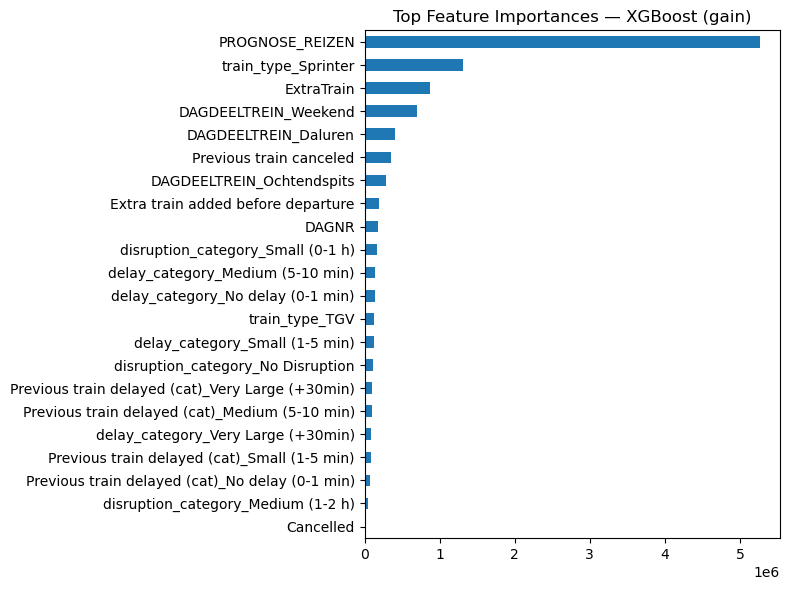

PermutationExplainer explainer: 1001it [03:40,  4.42it/s]                          
C:\Users\Alejandro Fiatt\AppData\Local\Temp\ipykernel_19936\3266308422.py:118: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test_small)


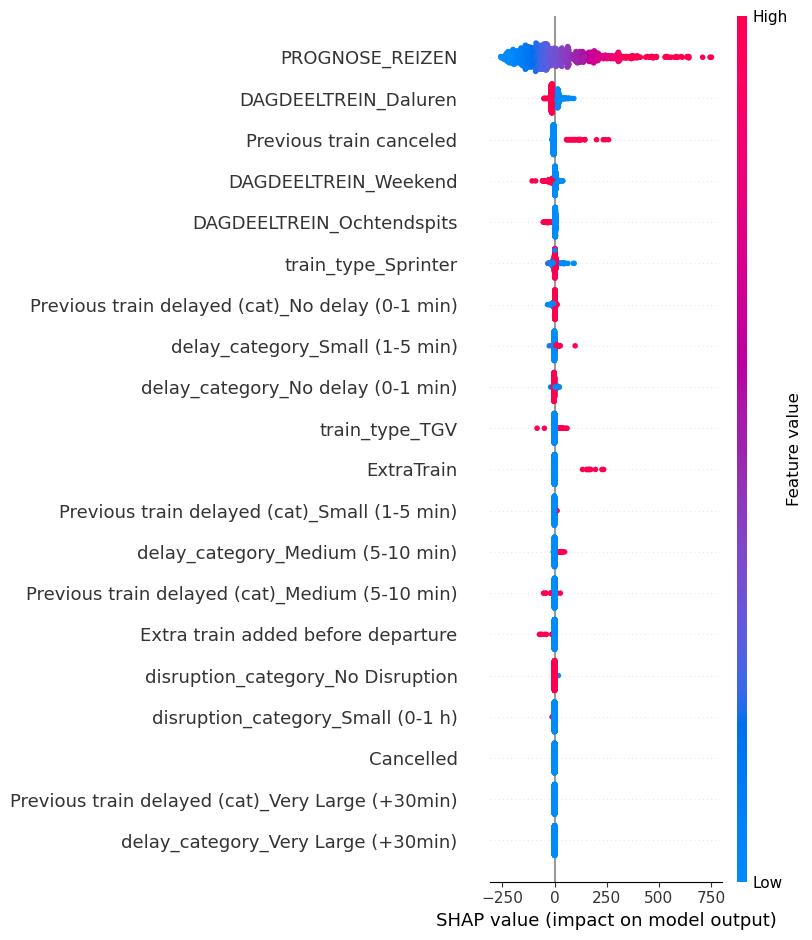

Features: 22
Gain Importance: 22
SHAP Mean |value|: 22
                                             Feature  Gain Importance  SHAP Mean |value|
0                                    PROGNOSE_REIZEN     5.268729e+06         134.430623
1                                train_type_Sprinter     1.312050e+06           5.332447
2                                         ExtraTrain     8.754539e+05           1.769891
3                               DAGDEELTREIN_Weekend     7.013766e+05           8.611847
4                               DAGDEELTREIN_Daluren     4.085359e+05          16.523664
5                            Previous train canceled     3.514457e+05           9.097978
6                          DAGDEELTREIN_Ochtendspits     2.789564e+05           7.522210
7                 Extra train added before departure     1.973676e+05           0.309034
8                                              DAGNR     1.761965e+05           0.000000
9                  disruption_category_Small (0-1 h)   

In [6]:
features = ["DAGNR", "DAGDEELTREIN", "train_type", "PROGNOSE_REIZEN", "Cancelled","ExtraTrain","Previous train canceled",
             "Previous train delayed (cat)", "Extra train added before departure", "delay_category", "disruption_category"]
X = df[features].copy()

# one-hot encode categoricals
categorical_cols = [c for c in ["DAGDEELTREIN","train_type","delay_category", "disruption_category","Previous train delayed (cat)"] if c in X.columns]
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# --- 4) Chronological split ---
cutoff_day = df["DAGNR"].max() - 7          # last 7 days as test
train_mask = df["DAGNR"] <= cutoff_day
test_mask  = df["DAGNR"] >  cutoff_day

X_train_full = X[train_mask]
y_train_full = y[train_mask]
X_test       = X[test_mask]
y_test       = y[test_mask]

print("Train full:", X_train_full.shape, "| Test:", X_test.shape)

# --- 5) Validation split inside training (chronological) ---
train_days = np.sort(df.loc[train_mask, "DAGNR"].unique())
val_days_count = max(1, int(0.2 * len(train_days)))  # ~20% of training days
val_days = set(train_days[-val_days_count:])
tr_days  = set(train_days[:-val_days_count]) if val_days_count < len(train_days) else set()

if len(tr_days) == 0:   # fallback if tiny
    val_days = set(train_days[-2:])
    tr_days  = set(train_days[:-2])

train_sub_mask = train_mask & df["DAGNR"].isin(tr_days)
valid_mask     = train_mask & df["DAGNR"].isin(val_days)

X_tr, y_tr = X[train_sub_mask], y[train_sub_mask]
X_va, y_va = X[valid_mask],     y[valid_mask]

print("Train sub:", X_tr.shape, "| Valid:", X_va.shape)

# --- 6) XGBoost (native API) with early stopping on validation ---
params = {
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "eta": 0.03,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "seed": 42
}

# Build DMatrices (pass feature names so importance lines up)
feature_names = list(X.columns)
dtrain = xgb.DMatrix(X_tr, label=y_tr, feature_names=feature_names)
dvalid = xgb.DMatrix(X_va, label=y_va, feature_names=feature_names)
dtest  = xgb.DMatrix(X_test, feature_names=feature_names)

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=[(dvalid, "valid")],
    early_stopping_rounds=200,
    verbose_eval=False
)

# --- 7) Evaluate on TEST set ---
y_pred = bst.predict(dtest)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("\nXGBoost (native, early-stopped on validation) — Test results:")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R²:", round(r2, 3))

# --- Operator baseline ---
if "PROGNOSE_REIZEN" in df.columns:
    op_pred  = df.loc[test_mask, "PROGNOSE_REIZEN"]
    op_mae   = mean_absolute_error(y_test, op_pred)
    op_rmse  = np.sqrt(mean_squared_error(y_test, op_pred))
    op_r2    = r2_score(y_test, op_pred)

    print("\nOperator Forecast (PROGNOSE_REIZEN) — Test results:")
    print("MAE:", round(op_mae, 2))
    print("RMSE:", round(op_rmse, 2))
    print("R²:", round(op_r2, 3))

# --- 8) Feature importance (gain) ---
score_dict = bst.get_score(importance_type="gain")
fi = pd.Series({f: score_dict.get(f, 0.0) for f in feature_names}).sort_values(ascending=True)
fi.plot(kind="barh", figsize=(8,6))
plt.title("Top Feature Importances — XGBoost (gain)")
plt.tight_layout()
plt.show()

# 1) Already one-hot encoded + align columns
X_test_enc = X_test.copy()
X_test_enc = X_test_enc.reindex(columns=feature_names, fill_value=0)

# 2) Force all numeric
X_test_enc = X_test_enc.astype(float)

# Optional: sample down for speed
X_test_small = X_test_enc.sample(min(1000, len(X_test_enc)), random_state=42)

# 3) Define prediction wrapper
def booster_predict(X):
    d = xgb.DMatrix(X, feature_names=list(X.columns))
    return bst.predict(d)

# 4) Black-box SHAP
explainer = shap.Explainer(booster_predict, X_test_small)
shap_values = explainer(X_test_small)

# 5) Plot
shap.summary_plot(shap_values.values, X_test_small)

# --- 4) SHAP mean |value| ---
shap_mean_abs = pd.Series(np.abs(shap_values.values).mean(axis=0), index=X_test_small.columns)

print("Features:", len(X_test_enc.columns))
print("Gain Importance:", len(fi.values))
print("SHAP Mean |value|:", len(shap_mean_abs.values))

# Ensure gain importance has all features and is in the same order
fi = pd.Series({f: score_dict.get(f, 0.0) for f in feature_names})
shap_mean_abs = pd.Series(np.abs(shap_values.values).mean(axis=0), index=X_test_small.columns)

# --- 5) Combine into a table ---
importance_table = pd.DataFrame({
    "Gain Importance": fi,
    "SHAP Mean |value|": shap_mean_abs
}).fillna(0).reset_index().rename(columns={"index": "Feature"})

# Optional: sort by SHAP importance
importance_table = importance_table.sort_values(by="Gain Importance", ascending=False).reset_index(drop=True)

# --- 6) Display ---
print(importance_table)

In [2]:
# --- 1) Setup ---
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 2) Load data ---
df = pd.read_csv(
    r"C:\Users\Alejandro Fiatt\Documents\GitHub\Group2_NS\complete_dataset_clean_24oct.csv",
    sep=";"
)

# --- 3) Data cleaning---

# drop rows with missing target
df = df.dropna(subset=["REALISATIE"]).reset_index(drop=True)
df["REALISATIE"] = df["REALISATIE"].astype(float)


# booleans to ints (safer for sklearn)
for col in ["Cancelled", "ExtraTrain", "Previous train canceled", "Previous train delayed (min)",'Extra train added before departure']:
    if col in df.columns:
        df[col] = df[col].astype(int)


# --- 4) Target and features ---
y = df["REALISATIE"]

base_features = ["DAGDEELTREIN", "train_type", "PROGNOSE_REIZEN"]

weather_features = [c for c in [
    "Rain_flag","Heavy_Rain_flag","Gusts_flag","Storms_flag","Warm_flag","Cold_flag","Sunny_flag"
] if c in df.columns]

disrupt_features = [c for c in [
    "Cancelled","ExtraTrain","delay_category","disruption_category",
    "Previous train canceled","Previous train delayed (cat)", 'Extra train added before departure', "disrupt_any", 
] if c in df.columns]


features_all = [c for c in (base_features + weather_features + disrupt_features) if c in df.columns]

features_all

['DAGDEELTREIN',
 'train_type',
 'PROGNOSE_REIZEN',
 'Rain_flag',
 'Heavy_Rain_flag',
 'Gusts_flag',
 'Storms_flag',
 'Warm_flag',
 'Cold_flag',
 'Sunny_flag',
 'Cancelled',
 'ExtraTrain',
 'delay_category',
 'disruption_category',
 'Previous train canceled',
 'Previous train delayed (cat)',
 'Extra train added before departure']

In [3]:
X = df[features_all].copy()

# one-hot encode categoricals
categorical_cols = [c for c in ["DAGDEELTREIN", "train_type", "delay_category", "disruption_category", "Previous train delayed (cat)"] if c in X.columns]
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"Total model features (post one-hot): {X.shape[1]}")

# --- 5) Chronological split: last 7 days as TEST ---
cutoff_day = df["DAGNR"].max() - 7
train_mask = df["DAGNR"] <= cutoff_day
test_mask  = df["DAGNR"] >  cutoff_day

X_train = X[train_mask]
y_train = y[train_mask]
X_test  = X[test_mask]
y_test  = y[test_mask]

print("Train:", X_train.shape, "| Test:", X_test.shape)

# --- 6) Train & evaluate Linear Regression on full feature set ---
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("\nLinear Regression — Test results (full feature set):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# Operator baseline on the same TEST split
op_test = df.loc[test_mask, "PROGNOSE_REIZEN"].astype(float)
op_mae  = mean_absolute_error(y_test, op_test)
op_rmse = np.sqrt(mean_squared_error(y_test, op_test))
op_r2   = r2_score(y_test, op_test)

print("\nOperator Forecast (PROGNOSE_REIZEN) — Test results:")
print(f"MAE: {op_mae:.2f}")
print(f"RMSE: {op_rmse:.2f}")
print(f"R²: {op_r2:.3f}")

# --- 7) Compare multiple feature subsets (aligned with trees-style features) ---
feature_sets = {
    "Set 1: Base + Delay cats": base_features + ["delay_category"],
    "Set 2: Base + Disruption cats": base_features + ["disruption_category"],
    "Set 3: Base + Weather": base_features + weather_features,
    "Set 4: Base + Disruptions full": base_features + disrupt_features,
    "Set 5: Base + Delay and Disruption cats": base_features + ["delay_category", "disruption_category"],
    "Set 6: ALL": features_all,  # 
    
}

# === Build comparison table (incl. disrupted metrics) & save the best overall-MAE model ===

# Consistent one-hot categories
FORCE_CAT = {"DAGDEELTREIN", "train_type", "delay_category", "disruption_category", "Previous train delayed (cat)"}

# Disrupted mask (OR rule)
NO_DELAY_LABEL = "no delay (0-1 min)"
NO_DISR_LABEL  = "no disruption"
NO_PREVDELAY_LABEL = "no delay (0-1 min)"
def disrupted_mask(idx):
    dcat = df.loc[idx, "delay_category"].astype(str).str.strip().str.lower() if "delay_category" in df.columns else "nan"
    disc = df.loc[idx, "disruption_category"].astype(str).str.strip().str.lower() if "disruption_category" in df.columns else "nan"
    dpc = df.loc[idx, "Previous train delayed (cat)"].astype(str).str.strip().str.lower() if "Previous train delayed (cat)" in df.columns else "nan"
    return (dcat != NO_DELAY_LABEL) | (disc != NO_DISR_LABEL) | (dpc != NO_PREVDELAY_LABEL)

test_idx = df.index[test_mask]
dis_mask_test = disrupted_mask(test_idx).values

results = []
best_overall = {"mae": np.inf, "name": None, "model": None, "cols": None}

for name, feat_list in feature_sets.items():
    # keep only existing cols
    feat_list = [c for c in feat_list if c in df.columns]
    X_sub = df[feat_list].copy()

    # one-hot: union of forced cats + auto object/string cols
    auto_cat = [c for c in feat_list if X_sub[c].dtype == "object" or pd.api.types.is_string_dtype(X_sub[c])]
    cat_cols = sorted(set(auto_cat) | (set(feat_list) & FORCE_CAT))
    X_sub = pd.get_dummies(X_sub, columns=cat_cols, drop_first=True)

    # split
    X_tr = X_sub[train_mask]
    y_tr = y[train_mask]
    X_te = X_sub[test_mask]
    y_te = y[test_mask]

    # fit plain Linear for fair comparison
    m = LinearRegression()
    m.fit(X_tr, y_tr)
    y_hat = m.predict(X_te)

    # overall metrics
    mae  = mean_absolute_error(y_te, y_hat)
    rmse = np.sqrt(mean_squared_error(y_te, y_hat))
    r2   = r2_score(y_te, y_hat)

    # disrupted-only metrics
    if dis_mask_test.any():
        mae_d  = mean_absolute_error(y_te[dis_mask_test], y_hat[dis_mask_test])
        rmse_d = np.sqrt(mean_squared_error(y_te[dis_mask_test], y_hat[dis_mask_test]))
        r2_d   = r2_score(y_te[dis_mask_test], y_hat[dis_mask_test])
    else:
        mae_d = rmse_d = r2_d = np.nan

    results.append({
        "Feature Set": name,
        "MAE (Model)": round(mae, 2),
        "RMSE (Model)": round(rmse, 2),
        "R² (Model)": round(r2, 3),
        "MAE (Disrupted)": round(mae_d, 2),
        "RMSE (Disrupted)": round(rmse_d, 2),
        "R² (Disrupted)": round(r2_d, 3),
        "n_features": X_tr.shape[1]
    })

    # keep best by overall MAE
    if mae < best_overall["mae"]:
        best_overall = {"mae": mae, "name": name, "model": m, "cols": X_sub.columns.tolist()}

# Operator baseline row (overall + disrupted)
op_test = df.loc[test_mask, "PROGNOSE_REIZEN"].astype(float).values
y_test_all = y_test.values
op_mae  = round(mean_absolute_error(y_test_all, op_test), 2)
op_rmse = round(np.sqrt(mean_squared_error(y_test_all, op_test)), 2)
op_r2   = round(r2_score(y_test_all, op_test), 3)

if dis_mask_test.any():
    op_mae_d  = round(mean_absolute_error(y_test_all[dis_mask_test], op_test[dis_mask_test]), 2)
    op_rmse_d = round(np.sqrt(mean_squared_error(y_test_all[dis_mask_test], op_test[dis_mask_test])), 2)
    op_r2_d   = round(r2_score(y_test_all[dis_mask_test], op_test[dis_mask_test]), 3)
else:
    op_mae_d = op_rmse_d = op_r2_d = np.nan

operator_row = {
    "Feature Set": "Operator Forecast (baseline)",
    "MAE (Model)": op_mae,
    "RMSE (Model)": op_rmse,
    "R² (Model)": op_r2,
    "MAE (Disrupted)": op_mae_d,
    "RMSE (Disrupted)": op_rmse_d,
    "R² (Disrupted)": op_r2_d,
    "n_features": 1
}

results_df = pd.DataFrame([operator_row] + results).sort_values(by="MAE (Model)").reset_index(drop=True)

# pretty print table
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.width", 220)
print("\n=== Comparison of feature sets (Linear Regression) ===")
print(results_df)

# Save THE model & context for later cells
THE_FEATURE_SET_NAME = best_overall["name"]
THE_FEATURE_COLUMNS  = best_overall["cols"]      # post-one-hot columns
THE_MODEL_PIPE       = best_overall["model"]     # already fit on train split columns above

print(f"\nSaved THE model: {THE_FEATURE_SET_NAME}  | Overall Test MAE={best_overall['mae']:.2f}  | n_features={len(THE_FEATURE_COLUMNS)}")

Total model features (post one-hot): 28
Train: (75158, 28) | Test: (23459, 28)

Linear Regression — Test results (full feature set):
MAE: 63.23
RMSE: 91.78
R²: 0.818

Operator Forecast (PROGNOSE_REIZEN) — Test results:
MAE: 61.69
RMSE: 99.62
R²: 0.786

=== Comparison of feature sets (Linear Regression) ===
                               Feature Set  MAE (Model)  RMSE (Model)  R² (Model)  MAE (Disrupted)  RMSE (Disrupted)  R² (Disrupted)  n_features
0           Set 4: Base + Disruptions full        59.39         90.61       0.823            63.55             97.78           0.812          21
1  Set 5: Base + Delay and Disruption cats        61.15         95.85       0.802            65.44            101.52           0.797          13
2                 Set 1: Base + Delay cats        61.20         95.89       0.802            65.53            101.60           0.797          10
3            Set 2: Base + Disruption cats        61.41         96.37       0.800            65.83            10

In [34]:
# Tune THE model's feature set (fix: rebuild from raw features, reapply one-hot, align columns)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# --- 1) Rebuild X from the RAW features of THE_FEATURE_SET_NAME, re-encode exactly like in Cell 1 ---
raw_feat_list = feature_sets[THE_FEATURE_SET_NAME]                   # raw columns (pre one-hot)
raw_feat_list = [c for c in raw_feat_list if c in df.columns]        # keep existing

X_raw = df[raw_feat_list].copy()

FORCE_CAT = {"DAGDEELTREIN","train_type","delay_category","disruption_category", "Previous train delayed (cat)"}
auto_cat = [c for c in raw_feat_list if X_raw[c].dtype == "object" or pd.api.types.is_string_dtype(X_raw[c])]
cat_cols = sorted(set(auto_cat) | (set(raw_feat_list) & FORCE_CAT))

X_enc = pd.get_dummies(X_raw, columns=cat_cols, drop_first=True)

# Align to the exact columns the saved model was trained on (order + presence)
X_enc = X_enc.reindex(columns=THE_FEATURE_COLUMNS, fill_value=0.0)

# --- 2) Chronological split + internal validation days (same logic as before) ---
cutoff_day = df["DAGNR"].max() - 7
train_mask = df["DAGNR"] <= cutoff_day
test_mask  = df["DAGNR"] >  cutoff_day

train_days = np.sort(df.loc[train_mask, "DAGNR"].unique())
val_days_count = max(1, int(0.2 * len(train_days)))
val_days = set(train_days[-val_days_count:])
tr_days  = set(train_days[:-val_days_count]) if val_days_count < len(train_days) else set()
if len(tr_days) == 0:
    val_days = set(train_days[-2:])
    tr_days  = set(train_days[:-2])

train_sub_mask = train_mask & df["DAGNR"].isin(tr_days)
valid_mask     = train_mask & df["DAGNR"].isin(val_days)

X_tr, y_tr = X_enc[train_sub_mask], df.loc[train_sub_mask, "REALISATIE"].astype(float)
X_va, y_va = X_enc[valid_mask],     df.loc[valid_mask, "REALISATIE"].astype(float)
X_te, y_te = X_enc[test_mask],      df.loc[test_mask,  "REALISATIE"].astype(float)

# --- 3) Disrupted masks (optional reporting) ---
NO_DELAY_LABEL = "no delay (0-1 min)"
NO_DISR_LABEL  = "no disruption"
def disrupted_mask(idx):
    dcat = df.loc[idx, "delay_category"].astype(str).str.strip().str.lower() if "delay_category" in df.columns else "nan"
    disc = df.loc[idx, "disruption_category"].astype(str).str.strip().str.lower() if "disruption_category" in df.columns else "nan"
    return (dcat != NO_DELAY_LABEL) | (disc != NO_DISR_LABEL)

va_dis = disrupted_mask(df.index[valid_mask]).values
te_dis = disrupted_mask(df.index[test_mask]).values

# --- 4) Candidates (linear + regularized) ---
cands = []
cands.append(("Linear", Pipeline([("scaler", StandardScaler(with_mean=False)), ("model", LinearRegression())])))
for a in [0.1, 1.0, 3.0, 10.0, 30.0, 100.0]:
    cands.append((f"Ridge({a})", Pipeline([("scaler", StandardScaler(with_mean=False)), ("model", Ridge(alpha=a, random_state=42))])))
for a in [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1.0]:
    cands.append((f"Lasso({a})", Pipeline([("scaler", StandardScaler(with_mean=False)), ("model", Lasso(alpha=a, max_iter=20000, random_state=42))])))
for a in [1e-3, 1e-2, 1e-1, 0.5]:
    for l1 in [0.2, 0.5, 0.8]:
        cands.append((f"ElasticNet(a={a},l1={l1})",
                      Pipeline([("scaler", StandardScaler(with_mean=False)),
                                ("model", ElasticNet(alpha=a, l1_ratio=l1, max_iter=20000, random_state=42))])))

# --- 5) Optimize for overall MAE on validation ---
best_label, best_pipe, best_val = None, None, np.inf
for label, pipe in cands:
    pipe.fit(X_tr, y_tr)
    y_hat_va = pipe.predict(X_va)
    mae_va = mean_absolute_error(y_va, y_hat_va)
    print(f"{label:<26} | VAL MAE (all): {mae_va:.3f}")
    if mae_va < best_val:
        best_val, best_pipe, best_label = mae_va, pipe, label

# --- 6) Evaluate tuned vs THE (untuned) on TEST with correct aligned design matrix ---
y_hat_te_tuned = best_pipe.predict(X_te)
mae_te  = mean_absolute_error(y_te, y_hat_te_tuned)
rmse_te = np.sqrt(mean_squared_error(y_te, y_hat_te_tuned))
r2_te   = r2_score(y_te, y_hat_te_tuned)

print(f"\nBest tuned: {best_label} | VAL MAE={best_val:.3f}")
print("Best tuned — TEST (all):  MAE={:.2f} RMSE={:.2f} R²={:.3f}".format(mae_te, rmse_te, r2_te))

# THE_MODEL_PIPE was trained in Cell 1 on the same column set. Use identical X_enc columns here:
y_hat_te_the = THE_MODEL_PIPE.predict(X_enc[test_mask])  # SAME X_enc design matrix / columns
mae_the  = mean_absolute_error(y_te, y_hat_te_the)
rmse_the = np.sqrt(mean_squared_error(y_te, y_hat_te_the))
r2_the   = r2_score(y_te, y_hat_te_the)
print("THE model — TEST (all):   MAE={:.2f} RMSE={:.2f} R²={:.3f}".format(mae_the, rmse_the, r2_the))

# --- 7) Choose model to carry forward ---
if mae_te <= mae_the:
    SELECTED_MODEL_NAME = f"Tuned {best_label}"
    SELECTED_PIPE = best_pipe
else:
    SELECTED_MODEL_NAME = f"Untuned Linear ({THE_FEATURE_SET_NAME})"
    SELECTED_PIPE = THE_MODEL_PIPE

print(f"\nSelected model for further steps: {SELECTED_MODEL_NAME}")

Linear                     | VAL MAE (all): 64.183
Ridge(0.1)                 | VAL MAE (all): 64.183
Ridge(1.0)                 | VAL MAE (all): 64.182
Ridge(3.0)                 | VAL MAE (all): 64.181
Ridge(10.0)                | VAL MAE (all): 64.177
Ridge(30.0)                | VAL MAE (all): 64.167
Ridge(100.0)               | VAL MAE (all): 64.129
Lasso(0.0001)              | VAL MAE (all): 64.183
Lasso(0.001)               | VAL MAE (all): 64.182
Lasso(0.01)                | VAL MAE (all): 64.178
Lasso(0.1)                 | VAL MAE (all): 64.133
Lasso(0.5)                 | VAL MAE (all): 63.988
Lasso(1.0)                 | VAL MAE (all): 63.909
ElasticNet(a=0.001,l1=0.2) | VAL MAE (all): 64.155
ElasticNet(a=0.001,l1=0.5) | VAL MAE (all): 64.166
ElasticNet(a=0.001,l1=0.8) | VAL MAE (all): 64.176
ElasticNet(a=0.01,l1=0.2)  | VAL MAE (all): 63.939
ElasticNet(a=0.01,l1=0.5)  | VAL MAE (all): 64.020
ElasticNet(a=0.01,l1=0.8)  | VAL MAE (all): 64.112
ElasticNet(a=0.1,l1=0.2)   | VA

In [35]:
# --- Standardized coefficients for BEST feature set model ---

from sklearn.preprocessing import StandardScaler

best_name = "Set 4: Base + Disruptions full"
best_features = feature_sets[best_name]
best_features = [c for c in best_features if c in df.columns]
X_best = df[best_features].copy()

# one-hot encode categoricals
cat_cols_best = [c for c in best_features if X_best[c].dtype == "object" or pd.api.types.is_string_dtype(X_best[c])]
X_best = pd.get_dummies(X_best, columns=cat_cols_best, drop_first=True)

# use only training split
X_train_best = X_best[train_mask]
y_train_best = y[train_mask]

# standardize and fit linear model
scaler = StandardScaler()
X_scaled_best = scaler.fit_transform(X_train_best)
model_std = LinearRegression()
model_std.fit(X_scaled_best, y_train_best)

# collect coefficients
std_coefs = pd.DataFrame({
    "Feature": X_train_best.columns,
    "Standardized_Coefficient": model_std.coef_,
    "AbsValue": np.abs(model_std.coef_)
}).sort_values("AbsValue", ascending=False)

print(f"\n=== Top 15 Standardized Coefficients — {best_name} ===")
print(std_coefs.head(15).to_string(index=False))


=== Top 15 Standardized Coefficients — Set 4: Base + Disruptions full ===
                                         Feature  Standardized_Coefficient   AbsValue
                                 PROGNOSE_REIZEN                202.564488 202.564488
                                      ExtraTrain                 31.954778  31.954778
                         Previous train canceled                 21.360845  21.360845
                            DAGDEELTREIN_Daluren                -21.182074  21.182074
                            DAGDEELTREIN_Weekend                -20.590666  20.590666
                       DAGDEELTREIN_Ochtendspits                -12.898063  12.898063
              Extra train added before departure                -11.920388  11.920388
    Previous train delayed (cat)_Small (1-5 min)                 10.135795  10.135795
 Previous train delayed (cat)_No delay (0-1 min)                  9.752856   9.752856
                  delay_category_Small (1-5 min)                 

In [36]:
# MLP on the same feature set


import tensorflow as tf
from tensorflow import keras

# --- 1) Rebuild from RAW features of THE_FEATURE_SET_NAME, re-encode, then align to THE_FEATURE_COLUMNS ---
raw_feat_list = feature_sets[THE_FEATURE_SET_NAME]
raw_feat_list = [c for c in raw_feat_list if c in df.columns]
X_raw = df[raw_feat_list].copy()

FORCE_CAT = {"DAGDEELTREIN","train_type","delay_category","disruption_category", "Previous train delayed (cat)"}
auto_cat = [c for c in raw_feat_list if X_raw[c].dtype == "object" or pd.api.types.is_string_dtype(X_raw[c])]
cat_cols = sorted(set(auto_cat) | (set(raw_feat_list) & FORCE_CAT))

X_enc = pd.get_dummies(X_raw, columns=cat_cols, drop_first=True)
# align exactly to the post-one-hot training columns used by THE model
X_enc = X_enc.reindex(columns=THE_FEATURE_COLUMNS, fill_value=0.0)

# --- 2) Chronological split + internal validation inside train ---
cutoff_day = df["DAGNR"].max() - 7
train_mask = df["DAGNR"] <= cutoff_day
test_mask  = df["DAGNR"] >  cutoff_day

train_days = np.sort(df.loc[train_mask, "DAGNR"].unique())
val_days_count = max(1, int(0.2 * len(train_days)))
val_days = set(train_days[-val_days_count:])
tr_days  = set(train_days[:-val_days_count]) if val_days_count < len(train_days) else set()
if len(tr_days) == 0:
    val_days = set(train_days[-2:])
    tr_days  = set(train_days[:-2])

train_sub_mask = train_mask & df["DAGNR"].isin(tr_days)
valid_mask     = train_mask & df["DAGNR"].isin(val_days)

X_tr = X_enc[train_sub_mask].values.astype("float32")
y_tr = df.loc[train_sub_mask, "REALISATIE"].astype(float).values.astype("float32")
X_va = X_enc[valid_mask].values.astype("float32")
y_va = df.loc[valid_mask, "REALISATIE"].astype(float).values.astype("float32")
X_te = X_enc[test_mask].values.astype("float32")
y_te = df.loc[test_mask,  "REALISATIE"].astype(float).values.astype("float32")

# --- 3) Scale (safe with one-hots) ---
scaler = StandardScaler(with_mean=False)
X_tr = scaler.fit_transform(X_tr)
X_va = scaler.transform(X_va)
X_te = scaler.transform(X_te)

# --- 4) MLP ---
tf.keras.backend.clear_session()
model = keras.Sequential([
    keras.layers.Input(shape=(X_tr.shape[1],)),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mae")
es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss", verbose=0)

model.fit(X_tr, y_tr, validation_data=(X_va, y_va),
          epochs=200, batch_size=1024, callbacks=[es], verbose=0)

# --- 5) Evaluate MLP vs the selected classical model on the EXACT same X_enc ---
y_pred_nn = model.predict(X_te, verbose=0).ravel()
mae_nn  = mean_absolute_error(y_te, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_te, y_pred_nn))
r2_nn   = r2_score(y_te, y_pred_nn)

y_hat_sel = SELECTED_PIPE.predict(X_enc[test_mask])  # uses same aligned matrix
mae_sel  = mean_absolute_error(y_te, y_hat_sel)
rmse_sel = np.sqrt(mean_squared_error(y_te, y_hat_sel))
r2_sel   = r2_score(y_te, y_hat_sel)

print(f"\nMLP — Test: MAE={mae_nn:.2f} RMSE={rmse_nn:.2f} R²={r2_nn:.3f}")
print(f"{SELECTED_MODEL_NAME} — Test: MAE={mae_sel:.2f} RMSE={rmse_sel:.2f} R²={r2_sel:.3f}")

print("Winner:", "MLP (lower MAE)" if mae_nn < mae_sel else "Selected linear model (lower MAE)")

# --- Disrupted-only metrics (delay != 'No delay (0-1 min)' OR disruption != 'No Disruption') ---

NO_DELAY_LABEL = "no delay (0-1 min)"
NO_DISR_LABEL  = "no disruption"

def disrupted_mask(idx):
    dcat = df.loc[idx, "delay_category"].astype(str).str.strip().str.lower() if "delay_category" in df.columns else "nan"
    disc = df.loc[idx, "disruption_category"].astype(str).str.strip().str.lower() if "disruption_category" in df.columns else "nan"
    return (dcat != NO_DELAY_LABEL) | (disc != NO_DISR_LABEL)

test_idx = df.index[test_mask]
dis_mask_test = disrupted_mask(test_idx).values
n_dis = int(dis_mask_test.sum())
print(f"\nDisrupted runs in TEST (OR rule): {n_dis} / {len(dis_mask_test)}")

if n_dis > 0:
    # MLP on disrupted
    mae_nn_d  = mean_absolute_error(y_te[dis_mask_test], y_pred_nn[dis_mask_test])
    rmse_nn_d = np.sqrt(mean_squared_error(y_te[dis_mask_test], y_pred_nn[dis_mask_test]))
    r2_nn_d   = r2_score(y_te[dis_mask_test], y_pred_nn[dis_mask_test])

    # Selected linear on disrupted (uses same aligned X_enc)
    y_hat_sel_d = y_hat_sel[dis_mask_test]
    mae_sel_d  = mean_absolute_error(y_te[dis_mask_test], y_hat_sel_d)
    rmse_sel_d = np.sqrt(mean_squared_error(y_te[dis_mask_test], y_hat_sel_d))
    r2_sel_d   = r2_score(y_te[dis_mask_test], y_hat_sel_d)

    # Operator baseline on disrupted (optional)
    op_test = df.loc[test_mask, "PROGNOSE_REIZEN"].astype(float).values
    op_test_d = op_test[dis_mask_test]
    mae_op_d  = mean_absolute_error(y_te[dis_mask_test], op_test_d)
    rmse_op_d = np.sqrt(mean_squared_error(y_te[dis_mask_test], op_test_d))
    r2_op_d   = r2_score(y_te[dis_mask_test], op_test_d)

    print("\nMLP — Disrupted runs:")
    print(f"MAE={mae_nn_d:.2f} RMSE={rmse_nn_d:.2f} R²={r2_nn_d:.3f}")

    print(f"{SELECTED_MODEL_NAME} — Disrupted runs:")
    print(f"MAE={mae_sel_d:.2f} RMSE={rmse_sel_d:.2f} R²={r2_sel_d:.3f}")

    print("Operator — Disrupted runs:")
    print(f"MAE={mae_op_d:.2f} RMSE={rmse_op_d:.2f} R²={r2_op_d:.3f}")
else:
    print("No disrupted runs found in test set.")


MLP — Test: MAE=57.18 RMSE=88.41 R²=0.832
Untuned Linear (Set 4: Base + Disruptions full) — Test: MAE=59.39 RMSE=90.61 R²=0.823
Winner: MLP (lower MAE)

Disrupted runs in TEST (OR rule): 7767 / 23459

MLP — Disrupted runs:
MAE=66.19 RMSE=102.17 R²=0.809
Untuned Linear (Set 4: Base + Disruptions full) — Disrupted runs:
MAE=67.74 RMSE=103.76 R²=0.804
Operator — Disrupted runs:
MAE=71.26 RMSE=113.18 R²=0.766


In [37]:
# --- 1) Rebuild from RAW features of THE_FEATURE_SET_NAME, re-encode, then align to THE_FEATURE_COLUMNS ---
raw_feat_list = feature_sets[THE_FEATURE_SET_NAME]
raw_feat_list = [c for c in raw_feat_list if c in df.columns]
X_raw = df[raw_feat_list].copy()

FORCE_CAT = {"DAGDEELTREIN","train_type","delay_category","disruption_category"}
auto_cat = [c for c in raw_feat_list if X_raw[c].dtype == "object" or pd.api.types.is_string_dtype(X_raw[c])]
cat_cols = sorted(set(auto_cat) | (set(raw_feat_list) & FORCE_CAT))

X_enc = pd.get_dummies(X_raw, columns=cat_cols, drop_first=True)
# align exactly to the post-one-hot training columns used by THE model
X_enc = X_enc.reindex(columns=THE_FEATURE_COLUMNS, fill_value=0.0)

# --- 2) Chronological split + internal validation inside train ---
cutoff_day = df["DAGNR"].max() - 7
train_mask = df["DAGNR"] <= cutoff_day
test_mask  = df["DAGNR"] >  cutoff_day

train_days = np.sort(df.loc[train_mask, "DAGNR"].unique())
val_days_count = max(1, int(0.2 * len(train_days)))
val_days = set(train_days[-val_days_count:])
tr_days  = set(train_days[:-val_days_count]) if val_days_count < len(train_days) else set()
if len(tr_days) == 0:
    val_days = set(train_days[-2:])
    tr_days  = set(train_days[:-2])

train_sub_mask = train_mask & df["DAGNR"].isin(tr_days)
valid_mask     = train_mask & df["DAGNR"].isin(val_days)

# --- Targets: residuals ---
y_all = df["REALISATIE"].astype(float).values
op_all = df["PROGNOSE_REIZEN"].astype(float).values
res_all = y_all - op_all

X_tr = X_enc[train_sub_mask].values.astype("float32")
y_tr = res_all[train_sub_mask].astype("float32")
X_va = X_enc[valid_mask].values.astype("float32")
y_va = res_all[valid_mask].astype("float32")
X_te = X_enc[test_mask].values.astype("float32")
y_te_abs = y_all[test_mask].astype("float32")        # absolute target for reporting
op_te = op_all[test_mask].astype("float32")          # operator baseline on test

# --- 3) Scale (safe with one-hots) ---
scaler = StandardScaler(with_mean=False)
X_tr = scaler.fit_transform(X_tr)
X_va = scaler.transform(X_va)
X_te = scaler.transform(X_te)

# --- 4) MLP on residuals ---
tf.keras.backend.clear_session()
model = keras.Sequential([
    keras.layers.Input(shape=(X_tr.shape[1],)),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)  # predicts residual
])
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mae")
es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss", verbose=0)

model.fit(X_tr, y_tr, validation_data=(X_va, y_va),
          epochs=200, batch_size=1024, callbacks=[es], verbose=0)

# --- 5) Reconstruct absolute predictions; compare to selected linear model ---
res_pred_nn = model.predict(X_te, verbose=0).ravel()
y_pred_nn_abs = op_te + res_pred_nn

mae_nn  = mean_absolute_error(y_te_abs, y_pred_nn_abs)
rmse_nn = np.sqrt(mean_squared_error(y_te_abs, y_pred_nn_abs))
r2_nn   = r2_score(y_te_abs, y_pred_nn_abs)

# Selected classical model (absolute) on same aligned matrix
y_hat_sel_abs = SELECTED_PIPE.predict(X_enc[test_mask])
mae_sel  = mean_absolute_error(y_te_abs, y_hat_sel_abs)
rmse_sel = np.sqrt(mean_squared_error(y_te_abs, y_hat_sel_abs))
r2_sel   = r2_score(y_te_abs, y_hat_sel_abs)

print(f"\nResidual MLP — Test (all): MAE={mae_nn:.2f} RMSE={rmse_nn:.2f} R²={r2_nn:.3f}")
print(f"{SELECTED_MODEL_NAME} — Test (all): MAE={mae_sel:.2f} RMSE={rmse_sel:.2f} R²={r2_sel:.3f}")
print("Winner:", "Residual MLP (lower MAE)" if mae_nn < mae_sel else "Selected linear model (lower MAE)")

# --- 6) Disrupted-only metrics (delay != 'No delay (0-1 min)' OR disruption != 'No Disruption') ---
NO_DELAY_LABEL = "no delay (0-1 min)"
NO_DISR_LABEL  = "no disruption"
def disrupted_mask(idx):
    dcat = df.loc[idx, "delay_category"].astype(str).str.strip().str.lower() if "delay_category" in df.columns else "nan"
    disc = df.loc[idx, "disruption_category"].astype(str).str.strip().str.lower() if "disruption_category" in df.columns else "nan"
    return (dcat != NO_DELAY_LABEL) | (disc != NO_DISR_LABEL)

test_idx = df.index[test_mask]
dis_mask_test = disrupted_mask(test_idx).values
n_dis = int(dis_mask_test.sum())
print(f"\nDisrupted runs in TEST (OR rule): {n_dis} / {len(dis_mask_test)}")

if n_dis > 0:
    # Residual MLP (absolute) on disrupted
    mae_nn_d  = mean_absolute_error(y_te_abs[dis_mask_test], y_pred_nn_abs[dis_mask_test])
    rmse_nn_d = np.sqrt(mean_squared_error(y_te_abs[dis_mask_test], y_pred_nn_abs[dis_mask_test]))
    r2_nn_d   = r2_score(y_te_abs[dis_mask_test], y_pred_nn_abs[dis_mask_test])

    # Selected linear on disrupted
    y_hat_sel_d = y_hat_sel_abs[dis_mask_test]
    mae_sel_d  = mean_absolute_error(y_te_abs[dis_mask_test], y_hat_sel_d)
    rmse_sel_d = np.sqrt(mean_squared_error(y_te_abs[dis_mask_test], y_hat_sel_d))
    r2_sel_d   = r2_score(y_te_abs[dis_mask_test], y_hat_sel_d)

    # Operator baseline on disrupted (optional)
    op_test_d = op_te[dis_mask_test]
    mae_op_d  = mean_absolute_error(y_te_abs[dis_mask_test], op_test_d)
    rmse_op_d = np.sqrt(mean_squared_error(y_te_abs[dis_mask_test], op_test_d))
    r2_op_d   = r2_score(y_te_abs[dis_mask_test], op_test_d)

    print("\nResidual MLP — Disrupted runs:")
    print(f"MAE={mae_nn_d:.2f} RMSE={rmse_nn_d:.2f} R²={r2_nn_d:.3f}")

    print(f"{SELECTED_MODEL_NAME} — Disrupted runs:")
    print(f"MAE={mae_sel_d:.2f} RMSE={rmse_sel_d:.2f} R²={r2_sel_d:.3f}")

    print("Operator — Disrupted runs:")
    print(f"MAE={mae_op_d:.2f} RMSE={rmse_op_d:.2f} R²={r2_op_d:.3f}")
else:
    print("No disrupted runs found in test set.")


Residual MLP — Test (all): MAE=57.24 RMSE=88.83 R²=0.830
Untuned Linear (Set 4: Base + Disruptions full) — Test (all): MAE=59.39 RMSE=90.61 R²=0.823
Winner: Residual MLP (lower MAE)

Disrupted runs in TEST (OR rule): 7767 / 23459

Residual MLP — Disrupted runs:
MAE=66.57 RMSE=102.76 R²=0.807
Untuned Linear (Set 4: Base + Disruptions full) — Disrupted runs:
MAE=67.74 RMSE=103.76 R²=0.804
Operator — Disrupted runs:
MAE=71.26 RMSE=113.18 R²=0.766


In [41]:
# --- Export test-week predictions for visualization (regular MLP) ---

# Create DataFrame with test indices (chronological)
test_idx = df.index[test_mask]
export_df = pd.DataFrame({
    "DAGNR": df.loc[test_idx, "DAGNR"].values,
    "TRAJECT": df.loc[test_idx, "TRAJECT"] if "TRAJECT" in df.columns else None,
    "PLANTIJD_VERTREK": df.loc[test_idx, "PLANTIJD_VERTREK"] if "PLANTIJD_VERTREK" in df.columns else None,
    "REALISATIE": y_te,                   # actuals
    "OPERATOR_PRED": df.loc[test_mask, "PROGNOSE_REIZEN"].astype(float).values,
    "LINEAR_PRED": SELECTED_PIPE.predict(X_enc[test_mask]),  # selected linear model
    "MLP_PRED": y_pred_nn,                 # regular MLP predictions
    "XGBOOST_PRED": y_pred                 # regular MLP predictions
})

# Sort chronologically (optional)
sort_cols = [c for c in ["DAGNR", "PLANTIJD_VERTREK"] if c in export_df.columns]
if sort_cols:
    export_df = export_df.sort_values(sort_cols, ignore_index=True)

# Save to CSV
export_path = r"C:\Users\Alejandro Fiatt\Documents\GitHub\Group2_NS\test_predictions_comparison_withXGBoost.csv"
export_df.to_csv(export_path, index=False)

print(f"\n✅ Test-week predictions exported to: {export_path}")
print(f"Columns: {list(export_df.columns)}")
print(f"Rows exported: {len(export_df)}")


✅ Test-week predictions exported to: C:\Users\Alejandro Fiatt\Documents\GitHub\Group2_NS\test_predictions_comparison_withXGBoost.csv
Columns: ['DAGNR', 'TRAJECT', 'PLANTIJD_VERTREK', 'REALISATIE', 'OPERATOR_PRED', 'LINEAR_PRED', 'MLP_PRED', 'XGBOOST_PRED']
Rows exported: 23459
